In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
from tensorflow import keras

tf.get_logger().setLevel('ERROR')

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

backend = keras.backend

import mplhep as hep
hep.style.use(hep.style.ATLAS)

In [2]:
import random

seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)

tf.config.experimental.enable_op_determinism()

In [3]:
from HGQ import set_default_kernel_quantizer_config, set_default_pre_activation_quantizer_config
from HGQ import HDense, HQuantize
from HGQ.bops import compute_bops, ResetMinMax, FreeBOPs
from HGQ import update_layerconf, create_replica, patch_hls4ml_project
from HGQ.hls4ml_hook import convert_from_hgq_model

In [4]:
beta = 2e-4

# The first layer must be quantized, either by using HQuantize or Signature layers.
# The input quantization layer's name must contain 'inp_q' if you want to quantize the input heterogeneously.
# Use only layers provided by HGQ. You can use functional API as well.
model = keras.Sequential([
    HQuantize(beta=beta, input_shape=(1,), name='inp_q'),
    HDense(3, activation='relu',beta=beta),
    HDense(3, activation='relu',beta=beta),
    HDense(3, activation='relu',beta=beta),
    HDense(1, beta=beta),
])

In [5]:
opt = keras.optimizers.Adam(learning_rate = 0.002)
loss = keras.losses.MeanSquaredError()
model.compile(loss = loss, optimizer = opt)
callbacks = [ResetMinMax(), FreeBOPs()]

In [6]:
x = np.random.uniform(-3, 3, 100000).astype(np.float32)
y = x**2

In [7]:
model.fit(x, y, batch_size=128, epochs=6, validation_split=0.1, callbacks=callbacks)

Epoch 1/6
704/704 [==============================] - 6s 5ms/step - loss: 2.8094 - val_loss: 0.4094 - multi: 292.0000
Epoch 2/6
704/704 [==============================] - 1s 2ms/step - loss: 0.2498 - val_loss: 0.3121 - multi: 279.0000
Epoch 3/6
704/704 [==============================] - 1s 2ms/step - loss: 0.1501 - val_loss: 0.1290 - multi: 267.0000
Epoch 4/6
704/704 [==============================] - 1s 2ms/step - loss: 0.1148 - val_loss: 0.2152 - multi: 248.0000
Epoch 5/6
704/704 [==============================] - 1s 2ms/step - loss: 0.1047 - val_loss: 0.1916 - multi: 261.0000
Epoch 6/6
704/704 [==============================] - 1s 1ms/step - loss: 0.0862 - val_loss: 0.1012 - multi: 248.0000


In [8]:
x0 = np.linspace(-3,3,2000).astype(np.float32)
yp = model.predict(x0, batch_size=1000, verbose=0) # type: ignore

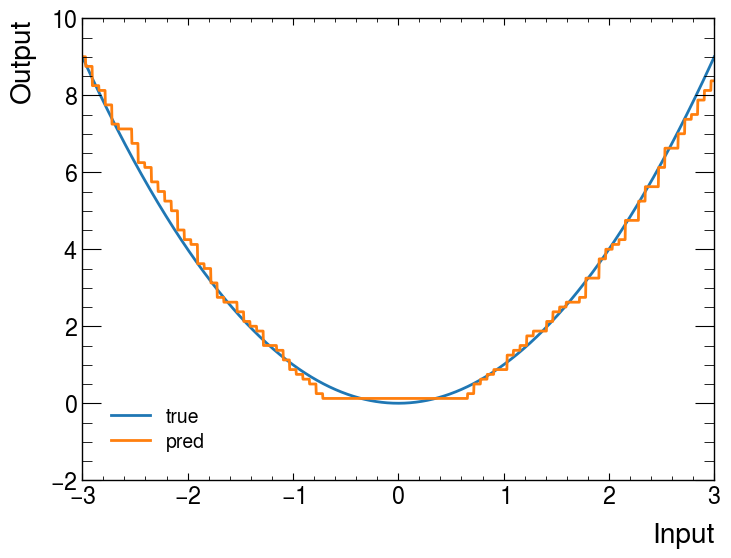

In [9]:
plt.axes(xlabel='Input', ylabel='Output')
plt.plot(x0, x0**2, label='true')
plt.plot(x0, yp, label='pred')
plt.legend()
plt.show()

In [10]:
compute_bops(model, x0, bsz=1000)

inp_q: 0.0
h_dense: 84.0
h_dense_1: 62.0
h_dense_2: 54.0
h_dense_3: 26.0


226.0

In [11]:
model_hls = convert_from_hgq_model(
    model,
    'hls4ml_prj',
    part='xcvu9p-flga2104-2L-e',
    clock_period=5,
    bias_accum=None
)

Interpreting Sequential
Topology:
Layer name: inp_q, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_dense, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 3]
Layer name: h_dense_1, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_2, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_3, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 1]
Interpreting Sequential
Topology:
Layer name: inp_q, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_dense, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 3]
Layer name: h_dense_1, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_2, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_3, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 1]
Crea

In [12]:
# Notice that the tarball file generated by hls4ml should NOT be used when using HGQ, as it is not patched.
model_hls.compile()

Writing HLS project
Done


In [13]:
hls_p = model_hls.predict(x0).ravel()
keras_p = model.predict(x0, batch_size=1000, verbose=0).ravel() # type: ignore

In [14]:
np.all(hls_p==keras_p)

True

In [15]:
# Bwlow shows how to do conversion manually

In [16]:
import hls4ml

In [17]:
# HGQ layers are not reecognized by hls4ml at the moment. Cast everything to standard layers and manually update the config file.
replica = create_replica(model, copy_weights=True)

hls_config = hls4ml.utils.config_from_keras_model(replica, granularity='name')
update_layerconf(model, hls_config, bias_accum=None)

Interpreting Sequential
Topology:
Layer name: inp_q, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_dense, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 3]
Layer name: h_dense_1, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_2, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_3, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 1]


In [18]:
# Do the conversion
model_hls = hls4ml.converters.convert_from_keras_model(
    replica,
    project_name='test',
    output_dir='hls4ml_prj_2',
    part='xcvu9p-flga2104-2L-e',
    clock_period=5,
    hls_config=hls_config,
    io_type='io_parallel',
)

Interpreting Sequential
Topology:
Layer name: inp_q, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_dense, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 3]
Layer name: h_dense_1, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_2, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_3, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 1]
Creating HLS model


In [19]:
# Write the model to disk, patch heterogenous activation bitwidths, and compile
model_hls.write()
patch_hls4ml_project('./hls4ml_prj_2', model)
model_hls.no_write_compile() # this method is hooked. It compile the model without overwriting the project.

Writing HLS project
Done


In [20]:
# model_hls.no_write_compile() # this method is hooked. It compile the model without overwriting the project.

In [21]:
hls_p = model_hls.predict(x0).ravel()
keras_p = model.predict(x0, batch_size=1024, verbose=0).ravel() # type: ignore

In [22]:
np.all(hls_p == keras_p)

True